# portfolio

> A module to model a portfolio's performance over the available time-scale including the impact of fees.

A notebook to explore different investment portfolio ideas and compare their historic returns, inclusive of fees

In [1]:
#| default_exp portfolio

In [115]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [116]:
#| export
from fastcore.utils import *

In [3]:
import yfinance as yf
import pendulum
%matplotlib inline

# Holding
A holding is an asset that can be bought. We need to track it's value and how much of it we own over time. We therefore need financial data which can be provided by yfinance for free.

Let's import the package and have a play. Remembering that when we are using `nbdev` we have to have imports in their own cells.

In [4]:
import yfinance as yf

In [5]:
price_history = yf.Ticker('VWELX').history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                           interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                           actions=False)
price_history.head()

,Open,High,Low,Close,Volume
Date,,,,,
1980-01-02,0.560007,0.560007,0.560007,0.560007,0
1980-01-03,0.557518,0.557518,0.557518,0.557518,0
1980-01-04,0.560629,0.560629,0.560629,0.560629,0
1980-01-07,0.560629,0.560629,0.560629,0.560629,0
1980-01-08,0.567474,0.567474,0.567474,0.567474,0


In [84]:
price_history.index[-1]

Timestamp('2023-01-03 00:00:00')

yfinance appears to be a good option as it has price information. One concern would be what units these are but that doesn't matter as we will convert back to cash at the end.

In [6]:
show_doc(yf.Ticker.history)

---

### TickerBase.history

>      TickerBase.history (period='1mo', interval='1d', start=None, end=None,
>                          prepost=False, actions=True, auto_adjust=True,
>                          back_adjust=False, proxy=None, rounding=False,
>                          tz=None, timeout=None, **kwargs)

:Parameters:
    period : str
        Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        Either Use period parameter or use start and end
    interval : str
        Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        Intraday data cannot extend last 60 days
    start: str
        Download start date string (YYYY-MM-DD) or _datetime.
        Default is 1900-01-01
    end: str
        Download end date string (YYYY-MM-DD) or _datetime.
        Default is now
    prepost : bool
        Include Pre and Post market data in results?
        Default is False
    auto_adjust: bool
        Adjust all OHLC automatically? Default is True
    back_adjust: bool
        Back-adjusted data to mimic true historical prices
    proxy: str
        Optional. Proxy server URL scheme. Default is None
    rounding: bool
        Round values to 2 decimal places?
        Optional. Default is False = precision suggested by Yahoo!
    tz: str
        Optional timezone locale for dates.
        (default data is returned as non-localized dates)
    timeout: None or float
        If not None stops waiting for a response after given number of
        seconds. (Can also be a fraction of a second e.g. 0.01)
        Default is None.
    **kwargs: dict
        debug: bool
            Optional. If passed as False, will suppress
            error message printing to console.

## Deposits

Deposits to our fund could be naturally specified as time series of deposits. A helper function is provided to support the creation of monthly deposits. However, this could be extended to different time periods.

In [7]:
import pandas as pd
from datetime import datetime

In [91]:
to_datetime = lambda date_string: datetime.strptime(date_string,"%d/%m/%Y")
def create_monthly_deposits(start:str,        # Date of the first montly deposit.
                            end:str,          # Date of the last monthly deposit
                            deposit:float):    # Value of monthly deposit
    dti = pd.date_range(start=to_datetime(start),end=to_datetime(end),freq='M')
    deposits = [deposit]*len(dti)
    return pd.Series([deposit]*len(dti), index=dti, name='deposits')

We call our function as follows.

In [137]:
monthly_deposits = create_monthly_deposits('21/01/1999','02/11/2022',10)
monthly_deposits

1999-01-31    100
1999-02-28    100
1999-03-31    100
1999-04-30    100
1999-05-31    100
             ... 
2022-06-30    100
2022-07-31    100
2022-08-31    100
2022-09-30    100
2022-10-31    100
Freq: M, Name: deposits, Length: 286, dtype: int64

## Single Holding
First we create a portfolio consisting of a single holding.

In [23]:
import matplotlib.pyplot as plt
import warnings

In [119]:
class Holding:
    "A holding for fund with data available on yfinance"
    def __init__(self,
                 fund:str,                      # Name of the fund
                 ticker:str,                    # Ticker symbol for the stock
                 product_cost:float,            # Sum of all fees expressed as a percentage
                 deposits):                     # Timeseries dataframe of deposits
                 
        
        self.fund = fund
        self.history = yf.Ticker(ticker).history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                 interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                 actions=False)
        
        # Where we've specified a timeseries where values predate the oldest time in our ticker,
        # we give a warning and then assume that the accumulated lump sum was invested at the earliest
        # possible date.
        if self.history.index[0] > deposits.index[0]:
            initial_deposit = deposits[deposits.index <= self.history.index[0]].sum()
            deposits = deposits[deposits.index <= self.history.index[0]]
            deposits.iat[0,0] = initial_deposit
            warnings.warn(f"""Deposits predate initial date of {self.history.index[0]} where prices are available for {fund}.
                              Accumulated deposit of {initial_deposit} deposited on this date.""")
        else:
             self.history = self.history.iloc[self.history.index >= deposits.index[0]]
            
        self.history['deposits']  =  deposits
        self.history['deposits']  = self.history['deposits'].fillna(0) 
        self.history['units']     = self.history['deposits']/self.history['Close']
        self.history['cum_units'] = self.history['units'].cumsum()
        self.history['cum_value'] = self.history['cum_units']*self.history['Close']
        self.history['fees'] = ((1+product_cost/100)**(1/365)-1)*self.history['cum_value']

Let's create our first holding.

In [101]:
single_holding = Holding('Vanguard LifeStrategy 100%','0P0000TKZO.L',0.22,create_monthly_deposits('01/01/2018','01/12/2022',1000))

Our holding should have the fund name assigned.

In [102]:
assert single_holding.fund == 'Vanguard LifeStrategy 100%'

Our holding should have a history dataframe...

In [103]:
assert isinstance(single_holding.history, pd.DataFrame)

with certain columns...

In [105]:
assert all([item in single_holding.history.columns for item in ['Open','High','Low','Close','deposits','units','cum_units','cum_value','fees']])

We could try and create a condition based on length of the dataframe but as the market is close on weekends we see that this is difficult.

In [107]:
len(single_holding.history)

1242

In [109]:
(yf.Ticker('0P0000TKZO.L').history(period='max',interval='1d',actions=False).index[-1]-to_datetime('04/01/2018')).days

1821

We can instead check the early dates in the history...

In [111]:
single_holding.history.head()

,Open,High,Low,Close,Volume,deposits,units,cum_units,cum_value,fees
Date,,,,,,,,,,
2018-01-31,20638.800781,20638.800781,20638.800781,20638.800781,0,1000.0,0.048452,0.048452,1000.000000,0.006021
2018-02-01,20603.599609,20603.599609,20603.599609,20603.599609,0,0.0,0.000000,0.048452,998.294418,0.006011
2018-02-02,20399.000000,20399.000000,20399.000000,20399.000000,0,0.0,0.000000,0.048452,988.381070,0.005951
2018-02-05,19985.199219,19985.199219,19985.199219,19985.199219,0,0.0,0.000000,0.048452,968.331418,0.005830
2018-02-06,19911.099609,19911.099609,19911.099609,19911.099609,0,0.0,0.000000,0.048452,964.741112,0.005809


and the later dates.

In [112]:
single_holding.history.tail()

,Open,High,Low,Close,Volume,deposits,units,cum_units,cum_value,fees
Date,,,,,,,,,,
2022-12-22,28378.429688,28378.429688,28378.429688,28378.429688,0,0.0,0.0,1.704366,48367.240102,0.291209
2022-12-23,28373.210938,28373.210938,28373.210938,28373.210938,0,0.0,0.0,1.704366,48358.345441,0.291156
2022-12-28,28231.150391,28231.150391,28231.150391,28231.150391,0,0.0,0.0,1.704366,48116.222227,0.289698
2022-12-29,28488.980469,28488.980469,28488.980469,28488.980469,0,0.0,0.0,1.704366,48555.659132,0.292344
2022-12-30,28414.650391,28414.650391,28414.650391,28414.650391,0,0.0,0.0,1.704366,48428.973449,0.291581


We might be interested in plotting the value of a holding over time. Let's patch in a method for that. `yfinfance` and `matplotlib` can be used if we want to just the price of a stock over time.

In [121]:
@patch
def plot(self:Holding):
    'Plot value of the holding'
    plt.plot(self.history['cum_value'])
    plt.xticks(rotation = 90)
    plt.title(self.fund)
    return plt

We use the `MonthLocator` to set the xtick positions.

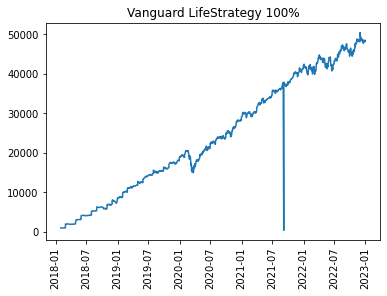

In [132]:
from matplotlib.dates import MonthLocator
plt = single_holding.plot()
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator([1,7]))

It would also be interesting to know our profit...

In [135]:
@patch
def profit(self:Holding):
    return self.history['cum_value'][-1]-sum(self.history['deposits'])

In [136]:
round(single_holding.profit())

7429

# Portfolio Modelling
For portfolio analysis, I'd like to explore the following features:
* Modelling a porfolio consisting of multiple funds.
* Rebalancing to target allocations.
* Rebalancing at given frequency.
    
Proposed structure would be lists of fund names, tickers, allocations and ongoing charges. A deposit rate would also need to be defined. Rebalancing times could be specified as a date series.

Future functionality might include:
* Variable allocation in time.
* At present if a fund's inception date is after the first deposit then cash deposits are accumulated until the first deposit opportunity. Another possible approach would be to split the capital just between the funds that are open at a given time. I think this is best handled by concatenating two FixedAllocationPortfolio funds.

In [ ]:
class FixedAllocationPortolio:
    "A collection of holdings of funds with data available on yfinance with a fixed allocation of each deposit made."
    def __init__(self,
                 fund:list,          # List of fund names
                 ticker:list,        # List of fund tickers
                 product_cost:list,  # List of fees for each fund expressed as a percentage and comprising all fees for a given fund
                 allocation:list,    # Allocation of each deposit as a fraction. Must sum to one.
                 deposits):          # Timeseries dataframe of deposits
        
        # Check fund, ticker, product_cost and allocation are all lists of equal length
        
        # Check that allocation sums to 1
        
        # Create a holding for each fund
        self.holdings = [Holding(fund[i],ticker[i],product_cost[i],deposits*allocation[i]) for i in range(len(fund))]
        
    def rebalance(self,rebalance_dates):
        
        # We rebalance on the dates specified. If a rebalancing date is prior a funds 
        # inception date then the fund is ignore in the rebalancing.
        
        # It is assumed that fees are paid for with an external account and that the fees are accrued daily.
        
        for date in rebalance_dates:
            
            # Find row closest to the rebalance date target
            matching_row = self.holdings[1].index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
            
            # Differences of 1 day are expected if our rebalance day falls on a weekend.
            
            # Compute the current allocation
            current_allocation = list()
            for i in range(len(self.holdings)):
                current_allocation.append(self.holdings[i].iloc[matching_row].loc['cum_value'])
                
            # Compute target allocations based on asset weightings
            # NaNs are skipped
            total_value = sum([element for element in current_allocation if str(element) != "nan"])
            target_allocation = [allocation*sum(value_breakdown) for allocation_fraction in allocation]
            
            # Update units, cum_units and cum_value in light of the new breakdown
            # These are really properties of the holding...
            cum_value_idx = self.holdings[i].columns.get_loc("cum_value")
            units_idx = self.holdings[i].columns.get_loc("units")
            cum_units_idx = self.holdings[i].columns.get_loc("cum_units")
            
            for i in range(len(self.holdings)):
                # Compute units deviation from the target
                units_delta = (self.holdings[i].iloc[matching_row,cum_value_idx] - target_allocation[i])/self.holdings[i].iloc[matching_row]['Close']
        
                # Update units entry to match target allocation
                self.holdings[i].iloc[matching_row,units_idx] -= units_delta
         
                # Update remaining rows
                self.holdings[i]['cum_units'] = self.holdings[i]['units'].cumsum()        
                self.holdings[i]['cum_value'] =  self.holdings[i]['cum_units']*self.holdings[i]['Close']
                self.holdings[i]['fees'] = ((1+product_cost[i]/100)**(1/365)-1)*self.holdings[i]['cum_value']

In [140]:
funds = ["Scottish Mortgage Ord","Fundsmith Equity I Acc"];
tickers = ["GB00BLDYK618","GB00B41YBW71"]
allocation = [0.5, 0.5]
annual_deposit = 20000
rebalance_rate = "monthly"
product_cost = [0.66, 0.99]

# Create data frames for each allocation
price_history_list = list()
for i in range(len(funds)):
    price_history = yf.Ticker(tickers[i]).history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                  interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                  actions=False)
    price_history['deposits']=[annual_deposit/365*allocation[i],]*len(price_history)
    price_history['units'] = price_history['deposits']/price_history['Close']
    price_history_list.append(price_history)

# Trim price_history_list to earliest date in portfolio
# Start by finding the first date data was available for each portfolio
first_timestamp = list ()
for price_history in price_history_list:
    first_timestamp.append(price_history.index[1])
start_date = max(first_timestamp)
    
# Now trim data and compute cumulutative values
for i in range(len(price_history_list)):
    price_history_list[i] = price_history_list[i][price_history_list[i].index >= start_date]
    price_history_list[i].insert(0,'cum_units',price_history_list[i]['units'].cumsum())
    price_history_list[i].insert(0,'cum_value',price_history_list[i]['cum_units']*price_history_list[i]['Close'])

# Rebalance
# Start by creating rebalance series
from datetime import datetime
import pandas as pd
rebalance_dates = pd.date_range(start_date,datetime.now(tz=None), freq='M')

# Find allocation of rebalance dates
for i_date in range(len(rebalance_dates)):
    
    # Find current asset allocation
    value_breakdown = list()
    for i_fund in range(len(price_history_list)):
        price_history = price_history_list[i_fund]
        matching_row = price_history.index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
        value_breakdown.append(price_history.iloc[matching_row].loc['cum_value']) # Include fees here?

    # Computer targer allocations based on asset weightings
    target_allocation = [allocation_fraction*sum(value_breakdown) for allocation_fraction in allocation]
    
    # Update units, cum_units and cum_value in light of the new breakdown
    for i_fund in range(len(price_history_list)):
        
        # Extract df of interest
        price_history = price_history_list[i_fund]
        
        # Find index locations for cells of interest
        matching_row = price_history.index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
        cum_value_idx = price_history.columns.get_loc("cum_value")
        units_idx = price_history.columns.get_loc("units")
        cum_units_idx = price_history.columns.get_loc("cum_units")
        
        # Compute units deviation from the target
        units_delta = (price_history.iloc[matching_row,cum_value_idx] - target_allocation[i_fund])/price_history.iloc[matching_row]['Close']
        
        # Update units entry to match target allocation
        price_history.iloc[matching_row,units_idx] -= units_delta
         
        # Update remaining rows
        price_history['cum_units'] = price_history['units'].cumsum()        
        price_history['cum_value'] =  price_history['cum_units']*price_history['Close']
        price_history['fees'] = ((1+product_cost[i_fund]/100)**(1/365)-1)*price_history['cum_value']
        
        # Update list with data frame including the new 
        price_history_list[i_fund] = price_history

In [ ]:
plt.plot(price_history_list[0].cum_units)

In [ ]:
# Compute final value
price_history = price_history_list[0]
for i_fund in range(1,len(price_history_list)):
    price_history['cum_value'] += price_history_list[i_fund]['cum_value']
    price_history['fees'] += price_history_list[i_fund]['fees']
    price_history['deposits'] += price_history_list[i_fund]['deposits']
    
price_history.head()

In [ ]:
plt.plot(price_history['cum_value'])
plt.plot()
plt.plot(price_history['deposits'].cumsum())
plt.xticks(rotation = 90)
plt.title('Current Portfolio')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))
profit = price_history["cum_value"][-2]-price_history['deposits'].sum()-price_history['fees'].sum()
print(profit)